In [0]:
import os
PLOT_DIR = os.path.join("data", "plots")
CSV_DIR = os.path.join("data", "csv")
os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(CSV_DIR, exist_ok=True)

In [0]:
comments = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/comments")
submissions = spark.read.parquet("abfss://anly502@marckvaismanblob.dfs.core.windows.net/reddit/parquet/submissions")

In [0]:
from pyspark.sql.functions import *

# Create the Dataset

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number
comment_content = comments.where(length(col("body")) < 500)
comment_content = comment_content.where(length(col("body")) > 300)
comment_content = comments.filter((col("subreddit")=='AskReddit')|(col("subreddit")=='FreeKarma4U')|(col("subreddit")=='GaySnapchat')|(col("subreddit")=='dirtykikpals')|(col("subreddit")=='memes')|(col("subreddit")=='teenagers')|(col("subreddit")=='dirtyr4r')|(col("subreddit")=='onlyfansgirls101')|(col("subreddit")=='jerkbudss')|(col("subreddit")=='AutoNewspaper')).cache()
windowSub = Window.partitionBy("subreddit").orderBy(col("score").desc())
df = comment_content.withColumn("row",row_number().over(windowSub)) \
      .filter(col("row") <= 30000)

# Selecting Columns

In [0]:
df2 = df.select('body','subreddit')
#drop missing value
df2 = df2.dropna(subset=('subreddit'))
df2 = df2.dropna(subset=('body'))
df2.show(10)

+--------------------+-----------+
|                body|  subreddit|
+--------------------+-----------+
|         Fuck Putin!|FreeKarma4U|
|Could you please ...|FreeKarma4U|
|           [removed]|FreeKarma4U|
|     karma to karma?|FreeKarma4U|
|                   E|FreeKarma4U|
|           [deleted]|FreeKarma4U|
|Ok humans... Only...|FreeKarma4U|
|           [removed]|FreeKarma4U|
|Upvoted. Any upvo...|FreeKarma4U|
|           [removed]|FreeKarma4U|
+--------------------+-----------+
only showing top 10 rows



# Basic Text Cleaning

In [0]:
cleaned_comment_content = df2.alias('cleaned_comment_content')
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '\&\w*;|#\w*;|@\w*', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '[^\w\s]', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '[0-9]', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', 'https?:\/\/.*\/\w*', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', 'RT|@', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '[-\.\n]', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', '\s\s+', ''))
cleaned_comment_content = cleaned_comment_content.withColumn('body', regexp_replace('body', "^\\s+|\\s+$", ''))

# StringIndexer

In [0]:
from pyspark.ml.feature import StringIndexer
labelEncoder = StringIndexer(inputCol='subreddit',outputCol='label').fit(cleaned_comment_content)
cleaned_comment_content = labelEncoder.transform(cleaned_comment_content)
cleaned_comment_content.show(10)

+--------------------+-----------+-----+
|                body|  subreddit|label|
+--------------------+-----------+-----+
|          Fuck Putin|FreeKarma4U|  1.0|
|Could you please ...|FreeKarma4U|  1.0|
|             removed|FreeKarma4U|  1.0|
|      karma to karma|FreeKarma4U|  1.0|
|                   E|FreeKarma4U|  1.0|
|             deleted|FreeKarma4U|  1.0|
|Ok humans Only co...|FreeKarma4U|  1.0|
|             removed|FreeKarma4U|  1.0|
|Upvoted Any upvot...|FreeKarma4U|  1.0|
|             removed|FreeKarma4U|  1.0|
+--------------------+-----------+-----+
only showing top 10 rows



In [0]:
cleaned_comment_content.filter(col('subreddit') == 'GaySnapchat').show(10)

+--------------------+-----------+-----+
|                body|  subreddit|label|
+--------------------+-----------+-----+
|I am reallty fasc...|GaySnapchat|  2.0|
|Thanks for the he...|GaySnapchat|  2.0|
|             deleted|GaySnapchat|  2.0|
|These type of peo...|GaySnapchat|  2.0|
|FYI hes straight ...|GaySnapchat|  2.0|
|Not very straight...|GaySnapchat|  2.0|
|Is your girlfrien...|GaySnapchat|  2.0|
|             deleted|GaySnapchat|  2.0|
|             deleted|GaySnapchat|  2.0|
|You really should...|GaySnapchat|  2.0|
+--------------------+-----------+-----+
only showing top 10 rows



# Create a Dictionary

In [0]:
label_dict = {'0.0':'AskReddit',
 '1.0':'FreeKarma4U',
 '2.0':'GaySnapchat',
 '3.0':'dirtykikpals',
 '4.0':'memes',
 '5.0':'teenagers',
 '6.0':'dirtyr4r',
 '7.0':'onlyfansgirls101',
 '8.0':'jerkbudss',
 '9.0':'AutoNewspaper'}

# Create a Logistic Regression Pipeline

In [0]:
import pyspark.ml.feature
from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, IDF

tokenizer = Tokenizer(inputCol='body',outputCol='mytokens')
stopwords_remover = StopWordsRemover(inputCol='mytokens',outputCol='filtered_tokens')
#vectorizer = CountVectorizer(inputCol='filtered_tokens',outputCol='rawFeatures')
hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol='rawFeatures',outputCol='vectorizedFeatures',minDocFreq=3)
pipeline = Pipeline(stages=[tokenizer,stopwords_remover,hashingTF,idf])
pipelineFit = pipeline.fit(cleaned_comment_content)
dataset = pipelineFit.transform(cleaned_comment_content)

In [0]:
dataset.show(10)

+--------------------+-----------+-----+--------------------+--------------------+--------------------+--------------------+
|                body|  subreddit|label|            mytokens|     filtered_tokens|         rawFeatures|  vectorizedFeatures|
+--------------------+-----------+-----+--------------------+--------------------+--------------------+--------------------+
|          Fuck Putin|FreeKarma4U|  1.0|       [fuck, putin]|       [fuck, putin]|(10000,[58,6599],...|(10000,[58,6599],...|
|Could you please ...|FreeKarma4U|  1.0|[could, you, plea...|[please, upvote, ...|(10000,[4255,4728...|(10000,[4255,4728...|
|             removed|FreeKarma4U|  1.0|           [removed]|           [removed]|(10000,[4414],[1.0])|(10000,[4414],[2....|
|      karma to karma|FreeKarma4U|  1.0|  [karma, to, karma]|      [karma, karma]|(10000,[5783],[2.0])|(10000,[5783],[9....|
|                   E|FreeKarma4U|  1.0|                 [e]|                 [e]|(10000,[3550],[1.0])|(10000,[3550],[6....|


# Split data into train and test dataset

In [0]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

# Build a LogisticRegression and do the prediction

In [0]:
lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label',maxIter=20, regParam=0.3, elasticNetParam=0)
lrModel = lr.fit(trainingData)
predictions = lrModel.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.5621214983387597


In [0]:
predictions.select("vectorizedFeatures","label","prediction").show(5)

+--------------------+-----+----------+
|  vectorizedFeatures|label|prediction|
+--------------------+-----+----------+
|(10000,[3372],[4....|  1.0|       7.0|
|(10000,[3372],[4....|  1.0|       7.0|
|(10000,[3372],[4....|  1.0|       7.0|
|(10000,[3372],[4....|  1.0|       7.0|
|(10000,[3372],[4....|  1.0|       7.0|
+--------------------+-----+----------+
only showing top 5 rows



# Model Selection and Hyperparameter Tuning and Saving the model

In [0]:
lr = LogisticRegression(featuresCol='vectorizedFeatures',labelCol='label', maxIter=20, regParam=0.3, elasticNetParam=0)
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.1, 0.3, 0.5]) # regularization parameter
             .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.2]) # Elastic Net Parameter (Ridge = 0)
#            .addGrid(model.maxIter, [10, 20, 50]) #Number of iterations
#            .addGrid(idf.numFeatures, [10, 100, 1000]) # Number of features
             .build())
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, \
                    estimatorParamMaps=paramGrid, \
                    evaluator=evaluator, \
                    numFolds=5)
cvModel = cv.fit(trainingData)
cvModel.save("LogisticRegression_model.model")


# Predict with the best model

In [0]:
from pyspark.ml.tuning import CrossValidatorModel

sameModel = CrossValidatorModel.load("dbfs:/LogisticRegression_model.model")

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = sameModel.transform(testData)
# Evaluate best model
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.5714888935806118


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

real_label = []
for label in class_temp:
    real_label.append(label_dict[str(label)])
real_label


Out[40]: ['dirtykikpals',
 'jerkbudss',
 'GaySnapchat',
 'FreeKarma4U',
 'AskReddit',
 'onlyfansgirls101',
 'memes',
 'dirtyr4r',
 'teenagers',
 'AutoNewspaper']

In [0]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.withColumn("label", y_true["label"].cast("string"))
#y_true.label = y_true.label.map(label_dict)
y_true = y_true.withColumn("label", translate(label_dict)("label"))
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.withColumn("prediction", y_pred["prediction"].cast("string"))
#y_pred.label = y_pred.label.map(label_dict)
y_pred = y_pred.withColumn("prediction", translate(label_dict)("prediction"))
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred, labels=real_label)
cnf_matrix

Out[51]: array([[8757,   18,   12,  180,    0,   19,   67,   11,   54,    1],
       [   0, 3861,  228,  526,  782,  438,  686, 1844,  635,   78],
       [   0,  348, 4900,  568,   42,  847,  874,  251, 1217,   15],
       [   0,  271,  194, 5625,   42, 1234,  539,  225,  959,    7],
       [   0, 1451,  101,  235, 4268,  172,  545, 1731,  344,  207],
       [   0,  398,  500, 1241,   59, 4930,  704,  311,  880,    9],
       [   0,  781,  229, 1436,  273,  426, 4548,  528,  736,   34],
       [   1, 1783,  180,  377,  907,  272,  577, 4160,  583,  132],
       [   0,  590,  534, 1541,   99,  576, 1166,  432, 3972,   16],
       [   0,  508,   45, 1701,  501,  111,  367,  693,  154, 4583]])

Confusion matrix, without normalization
[[8757   18   12  180    0   19   67   11   54    1]
 [   0 3861  228  526  782  438  686 1844  635   78]
 [   0  348 4900  568   42  847  874  251 1217   15]
 [   0  271  194 5625   42 1234  539  225  959    7]
 [   0 1451  101  235 4268  172  545 1731  344  207]
 [   0  398  500 1241   59 4930  704  311  880    9]
 [   0  781  229 1436  273  426 4548  528  736   34]
 [   1 1783  180  377  907  272  577 4160  583  132]
 [   0  590  534 1541   99  576 1166  432 3972   16]
 [   0  508   45 1701  501  111  367  693  154 4583]]


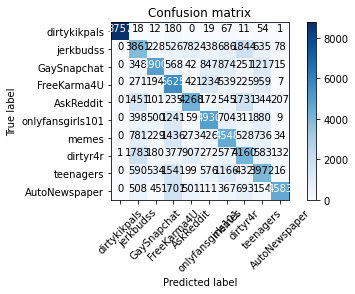

In [0]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=real_label,
                      title='Confusion matrix')
plot_fpath = os.path.join(PLOT_DIR, 'LogisticRegression_confusion_matrix.png')

plt.savefig(plot_fpath)
plt.show()

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=accuracy
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])

import pandas as pd
evaluation = pd.DataFrame({'evaluation':['accuracy','precision','recall'],'value':[accuracy,precision,recall]})
fpath = os.path.join(CSV_DIR, "LogisticRegression_evaluation.csv")
evaluation.to_csv(fpath)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
import pandas as pd
logistic_df = pd.read_csv('data/csv/LogisticRegression_evaluation.csv')
print(logistic_df)


   Unnamed: 0 evaluation     value
0           0   accuracy  0.571489
1           1  precision  0.992011
2           2     recall  0.949851


# Use the RandomForest Classifier

In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="vectorizedFeatures", \
                            numTrees = 100, \
                            maxDepth = 4, \
                            maxBins = 32)
# Train model with Training Data
rfModel = rf.fit(trainingData)


In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = rfModel.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.39815318969253166


In [0]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", \
                            featuresCol="vectorizedFeatures", \
                            numTrees = 50, \
                            maxDepth = 20, \
                            maxBins = 32)
# Train model with Training Data
rfModel2 = rf.fit(trainingData)

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

predictions = rfModel.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol='label',predictionCol='prediction',metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print(accuracy)

0.39694198437656264


Confusion matrix, without normalization
[[8734   12    6    2   10    1  206  104   44    0]
 [   0  382  159   14 2079   49  316 5783  194  102]
 [  11   98 2409   13  167  941 2122 3009  309   15]
 [ 388  121  110 1933  238  123  936 4364  830   19]
 [   4  215  145   23 4203   73  274 3845  132  140]
 [  26  109  657   12  281 2936  759 3792  427   33]
 [  10  295  103   25  888   38 3274 3940  321   97]
 [   1  311  188   23 1974   57  250 5865  138  165]
 [  79  218  557   40  489   71  954 5054 1425   41]
 [   0   43  118   10  809   21 1768 1913   56 3925]]


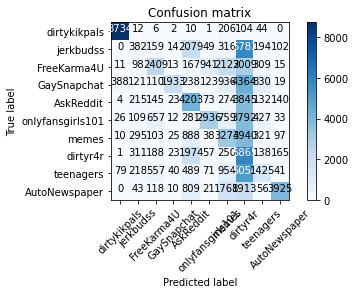

In [0]:
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_temp = class_temp["label"].values.tolist()

real_label = []
for label in class_temp:
    real_label.append(label_dict[str(label)])

from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())


from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.withColumn("label", y_true["label"].cast("string"))
#y_true.label = y_true.label.map(label_dict)
y_true = y_true.withColumn("label", translate(label_dict)("label"))
y_true = y_true.toPandas()

y_pred = predictions.select("prediction")
y_pred = y_pred.withColumn("prediction", y_pred["prediction"].cast("string"))
#y_pred.label = y_pred.label.map(label_dict)
y_pred = y_pred.withColumn("prediction", translate(label_dict)("prediction"))
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred, labels=real_label)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=real_label,
                      title='Confusion matrix')
plot_fpath = os.path.join(PLOT_DIR, 'RandomForest_confusion_matrix.png')

plt.savefig(plot_fpath)
plt.show()

In [0]:
from pyspark.mllib.evaluation import MulticlassMetrics

results = predictions.select(['prediction', 'label'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=accuracy
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])

import pandas as pd
evaluation = pd.DataFrame({'evaluation':['accuracy','precision','recall'],'value':[accuracy,precision,recall]})
fpath = os.path.join(CSV_DIR, "RandomForest_evaluation.csv")
evaluation.to_csv(fpath)

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
import pandas as pd
Random_df = pd.read_csv('data/csv/RandomForest_evaluation.csv')
print(Random_df)

   Unnamed: 0 evaluation     value
0           0   accuracy  0.396942
1           1  precision  0.978480
2           2     recall  0.968941
